# How the atmosphere mixing the ocean surface boundary layer
I. Giddy 2023
Adapted from Ilker Fer.

More details on the model:
Kraus EB, Turner JS (1966) A one-dimensional model of the seasonal thermocline. Tellus 19:88–97

If not running on Binder.org, this code is dependent on numpy, matplotlib, and pandas. 


This assignment is about the upper ocean, particularly the mixed layer and the pycnocline below, and its response to different atmospheric forcing. In order to simplify the physics and avoid complexity, one-dimensional (1D, vertical) solutions will be obtained and discussed. 

We will be using a bulk mixed layer model, the Krauss and Turner bulk mixed layer model, which solves for the depth of the mixed layer and its bulk properties (mixed layer average density, temperature, salinity) based on the net surface buoyancy flux and wind-induced mixing. 

The intricacies of the model are not the focus of this practical, but if you are interested in a more detailed description see Kraus EB, Turner JS (1966) A one-dimensional model of the seasonal thermocline. Tellus 19:88–97. 

For the sake of this experiment, we will assume that no horizontal processes are at play. 


### Functions

The below functions are used in the practical. Run them before starting. 

In [1]:
#this makes a generic CTD profile
def make_CTDprofile_continuous(NBV=0.015,T0=10,S0=34,H=100):
    """
    %
    % profile=make_CTDprofile_continuous(NBV,T0,S0,H)
    %
    % Generates a CTD profile for given constant buoyancy frequency, NBV (in rad/s),
    % starting from top level temperature T0 and salinity S0. 
    % Output (profile) is consistent with the PWP engine:
    %     z: depth +ve downward, (pressure-like)
    %     t: temperature
    %     s: salinity
    %     d: density
    % 
    % Default values:
    % NBV=0.015; # rad/s, buoy freq
    % T0=10; S0=34; # top level temperature and salinity
    % H=100; # total depth
    % assumes typical coeff of thermal expansion and haline contraction,
    % and a density ratio of -2 
    %
    % by Ilker Fer, November 2018, for GEOF310 Assignment
    % adapted by I. Giddy November 2020 for python
    % --------------------
    """

    import numpy as np
    import gsw as gsw
    import pandas as pd

    M=102
    dz=H/(M-2)
    rho0=gsw.rho(S0,T0,0)
    alp=1.5e-4
    bet=7.5e-4
    Rrho = -2 #density ratio (alpha dT / beta dS)

    z=np.arange(0,H,dz)*-1
    rho=rho0-(NBV**2/9.81*rho0*z)

    T=T0+(-(rho-rho0)/rho0)/(alp*(1-(1/Rrho)))
    S=S0 + ((alp*(T-T0)/Rrho)/bet)

    d = gsw.rho(S,T,0)  #density referenced to the surface
    
    # make pandas dataframe 
    
    df = pd.DataFrame({'z':-z,'t':T,'s':S,'d':d})

    return df


In [2]:
# Kraus-Turner Bulk Mixed Layer Model
def KrausTurner_engine(STRAT,FORCE,duration,PAR):
    
    """

     A function to solve the Krauss Turner bulk layer model based on the 
     formulations in Olbers, Willebrand and Eden (Ocean Dynamics text book)

     Initial stratification, STRAT = 
                 h0: mixed layer depth
             dtop: top layer density
             dbot: bottom layer density
         TotalDepth: total water depth

     Forcing, FORCE = 
          tau: wind stress, N/m2
           FH: net heat flux, W/m2, +ve vertical up, >0 convection; <0 stabilizing
        Bpyc: buoyancy flux induced by turbulent mixing in the pycnocline. Turbulent
               mixing induces <0, put a negative value or zero
     Model PARAMETERS
     PAR.r1 = 0.1
     PAR.r2 = 0.9
     PAR.c = 1

     Output returns time evolution of:
         time: in days
         zML: mixed layer depth
          d: mixed layer density

     by Ilker Fer, November 2018, for GEOF310 Assignment
     adapted by I. Giddy November 2020 for python
    """
    
    import numpy as np
    
    
    # Just to convert to formulations in p358 in 
    # Olbers, Willebrand and Eden (Ocean Dynamics) text book 
    # Follow notation, 
    # Buoy flux, letter Q, is positive downward in the ocean
    # with Q<0 convection, and Q>0 stable buoy flux (that is turbulence in
    # stable stratification induces downward buoy flux
    #
    #

    # prescribed parameters in the model
   # r1 = PAR.r1 # fraction of tau dissipated
   # r2 = PAR.r2 # fraction of convective Bo dissipated
   # c = PAR.c # approx 1, for work done by the wind stress
    
    r1 = 0.1
    r2 = 0.9
    c = 1
    
    # PARAMETERS
    rho0=1028 #reference density
    rhotop = STRAT.dtop.values[0]
    rhobot = STRAT.dbot.values[0]
    # Initial mixed layer depth
    h0=STRAT.h0.values[0]
    D=STRAT.TotalDepth.values[0]

    #wind stress in  N/m^2, converted to kinematic:
    tau=np.array(FORCE.tau/rho0)
    heatflux = np.array(-FORCE.FH) # W/m2, net radiation, converted to Eden's 
    # heatflux<0 convection; >0 stabilizing
    BPYC=np.array(-FORCE.Bpyc) # convert to Eden: buoy flux at the base of ML, turbulent mixing induces downward
    # buoy flux. Set to nil or a small +ve (downward) number representative of shear induced
    # mixing
    
    # ------- START --------- #
    # convert to buoyancy
    b00 = -(9.8/rho0)*(rhotop-rho0)
    bst = -(9.8/rho0)*(rhobot-rho0)


    dt=900; # time step, s
    ti = np.arange(0,duration,dt/(3600*24))
    
    # In case of constant forcing, generate forcing at all times
    # If time variable, interpolate FORCE.time to model time
    if 'time' in FORCE.keys():# & (len(tau)>1) :
        heatflux = np.interp1(FORCE.time,heatflux,ti)
        tau = np.interp1(FORCE.time,tau,ti)
        BPYC = np.interp1(FORCE.time,BPYC,ti)
    else:
        heatflux = np.ones(len(ti))*heatflux
        tau = np.ones(len(ti))*tau
        BPYC = np.ones(len(ti))*BPYC
    ###
    
    # define arrays to fill
    # sign convention for buoy flux, +ve upward
    # B>0 convection; B<0 stable

    h = [h0]
   # h = np.ndarray(len(D))
    b0 = [b00]
    #h[0]=h0 # thickness of ML   # CHECK THESE
    #b0[0]=b00 # buoyancy anomaly in the ML
    
    

    for I in range(1,len(ti)):   #change from 2 to 1 becuase of indexing convention in python

        Q0=((9.8*1.5e-4)/(rho0*4000))*heatflux[I-1] # surface buoy flux
        Qst = BPYC[I-1] #buoy flux at the base of the pycnocline, turbulent mixing induces <0

        windwork = c*(abs(tau[I-1])**(1.5))
        if Q0<0: #convection
          #  Diss = r1*windwork + r2*(h[I-1]/4)*(abs(Q0)-Q0)    # Dissipation integrated over h
            Diss = r1*windwork + r2*(h[I-1]/4)*(abs(Q0)-Q0)    # Dissipation integrated over h
        else: #stress only
            
            Diss = r1*windwork  # Dissipation integrated over h
#        
    
        Qh = (2/h[I-1])*((1-r1)*windwork - (h[I-1]/2)*(((1-(r2/2))*Q0)+(r2/2*abs(Q0))))
#
        if np.any(Qh) < 0:# stable, Q0>0
            h.append(((2*(1-r1)*windwork) / (Qh + (((1-(r2/2))*Q0)+(r2/2*abs(Q0))))))  # work out indexing
            dbdt = Q0/h[I-1]
            b0.append((b0[I-1]+(dbdt*dt)))
#    #         Qh = 0
#    #        h(I) = 2*(1-r1)*windwork/Q0; 
           
        else: # deepening
            dbdt = (Q0 - Qh)/h[I-1]
            b0.append((b0[I-1]+(dbdt*dt)))
            dhdt = (Qh - Qst)/(b0[I] - bst)
            h.append(((h[I-1]+(dhdt*dt))))
        
        if np.any(h[I]>D):
            h.append(D)

    # convert lists to arrays
    h=np.array(h)
    b0=np.array(b0)
            
    # convert buoyancy anomaly in the ML to density:
    rho =rho0 -(rho0*b0/9.8)
#     print(len())
    # create a dataframe for outputing
    df = pd.DataFrame({'time':ti,
                      'zML':h,
                      'd':rho})
    return df

How does the mixed layer respond to different atmospheric forcing? 

Generate a 2-layer density profile with an initial mixed layer depth of 25 m. Use the python function make_CTDprofile_continuous and average the upper 25 m to one value and the deeper layers to another value. Run for a 15 day duration, and discuss the evolution of mixed layer depth and mixed layer density for different cases.

a) weak wind stress and warming (stabilizing heat flux)

b) strong wind stress and warming (stabilizing heat flux)

c) weak wind stress and convection (destabilizing heat flux)

d) strong wind stress and convection (destabilizing heat flux)

With each scenario, describe how 1) the mixed layer depth changes, 2) the density changes and 3) what drives these changes


## Create a CTD profile

In [3]:
# make a CTD profile
import matplotlib.pyplot as plt

df = make_CTDprofile_continuous(NBV=0.015,T0=10,S0=34,H=300)  

#let's make a 2-layer profile, 25-m mixed layer

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

hML = 25  # initial mixed layer depth\

ind_top = df.index[np.abs(df.z)<hML]  
df.t[ind_top]=np.mean(df.t.iloc[ind_top]) 
df.s[ind_top]=np.mean(df.s.iloc[ind_top])
df.d[ind_top]=np.mean(df.d.iloc[ind_top])

ind_bot = df.index[np.abs(df.z)>=hML]

df.t[ind_bot]=np.mean(df.t.iloc[ind_bot])
df.s[ind_bot]=np.mean(df.s.iloc[ind_bot])
df.d[ind_bot]=np.mean(df.d.iloc[ind_bot])


Text(0.5, 0, 'Density')

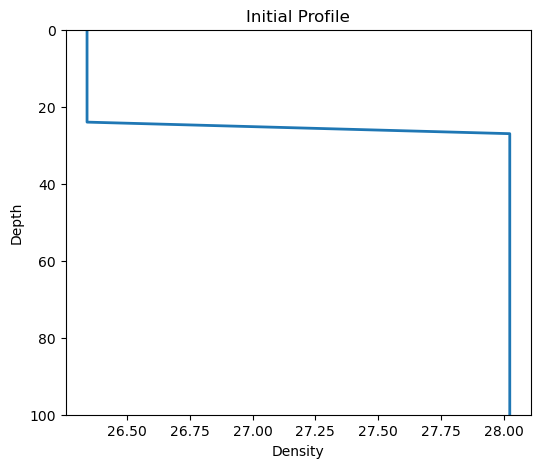

In [4]:
# visualise your initial profile

plt.figure(figsize=[6,5])
plt.title('Initial Profile')

plt.plot(df.d-1000,df.z,lw='2')
plt.ylim(100,0)
plt.ylabel('Depth')
plt.xlabel('Density')


In [16]:
#######
### Return here and edit this block for each scenario
######

import pandas as pd
import numpy as np

FORCE = pd.DataFrame({'FH':0,    #<<< EDIT THIS heat flux - note positive out of the ocean (cooling)
                     'tau':0.2,    #<<<< EDIT THIS wind stress
                     'fcorio':1e-4},index=[0])

# For Kraus and Turner

FORCE['Bpyc'] = -1e-8 #  W/kg

STRAT = df
STRAT['h0'] = hML # initial mixed layer depth
STRAT['dtop'] = df.d.iloc[0] # surface density
STRAT['dbot'] = df.d.iloc[-1] # density at the bottom of the profile
STRAT['TotalDepth'] = np.nanmax(np.abs(df.z))

PAR = pd.DataFrame({'r1': 0.1,
                    'r2': 0.9,
                     'c':1},index=[0])

duration = 15

## Case 1: Neutral conditions: Buoyancy flux is 0 and wind stress is weak
Set tau to 0.05 and FH to 0
## Case 2: Stabilising conditions: Buoyancy flux is negative (e.g. occean is warming) and wind stress is weak
Set tau to 0.05 and FH to -250
## Case 3: Convection: Buoyancy flux is positive (ocean is cooling) and wind stress is weak
Set tau to 0.05 and FH to 150


In [17]:
kt=KrausTurner_engine(STRAT,FORCE,duration,PAR)

Text(0, 0.5, 'density (kg/m3)')

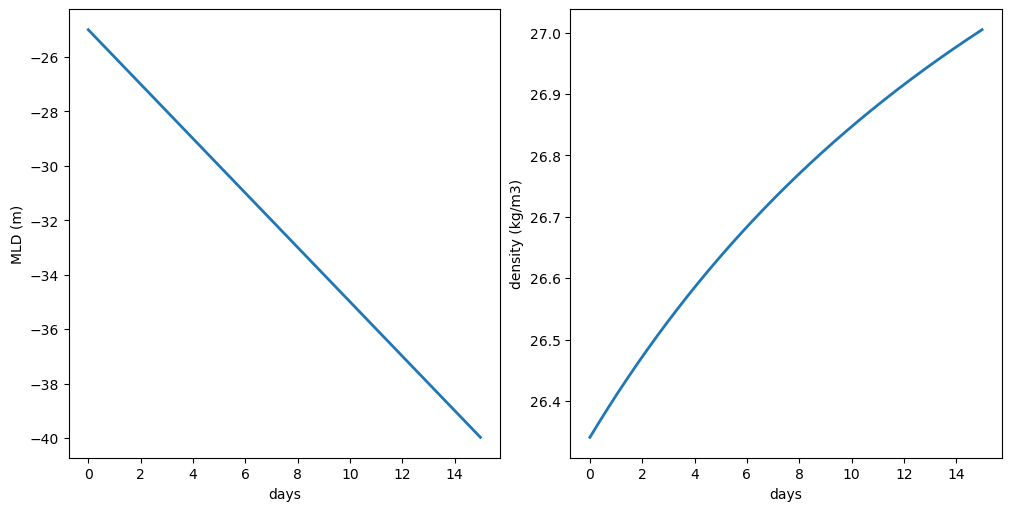

In [18]:
fig,ax=plt.subplots(1,2,figsize=[10,5],constrained_layout=True)
ax[0].plot(kt.time,kt.zML*-1,lw=2,c='tab:blue')

ax[0].set_xlabel('days')
ax[0].set_ylabel('MLD (m)')
# ax[0].legend()

ax[1].plot(kt.time,kt.d-1000,lw=2,c='tab:blue')

ax[1].set_xlabel('days')
ax[1].set_ylabel('density (kg/m3)')